In [1]:
#%load_ext line_profiler
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac
import h5py
import scipy
from collections import namedtuple
from standing_waves import remove_standing_waves

edge_chan = 1024

In [ ]:
mir_data = MirParser("/mnt/Storage1/Ozone/OzoneData/211009_04:56:19", has_auto=True)
freq_range = [min(mir_data.sp_data['fsky']) - 2.0, max(mir_data.sp_data['fsky']) + 2.0]
ozone_model = Ozone('/mnt/Storage1/Ozone/newdata/', freq_range = freq_range)
pwv = 2
_ = ozone_model(zenith=0.1, pwv=pwv, return_pwv_jacobian=True)

In [3]:
with h5py.File('../src/data/10923_specsoln.mat') as compass_solns:
    bp_arr = np.square(compass_solns['bandpassArr']).sum(axis=-1)
    freq_arr = np.divide(compass_solns['freqArr'], 1e9)
    scale_fac = np.swapaxes(np.asarray(compass_solns['gainApEff']).reshape(8, 2, -1), axis1=0, axis2=1)
    sb_arr = compass_solns['sbArr'][0]
    win_arr = compass_solns['winArr'][0]
    rx_arr = compass_solns['rxList'][0]


nWin = int(max(win_arr))
nSB = int(max(sb_arr) + 1)
nChan = 16384
SolnKey = namedtuple('SolnKey', ['Antenna', 'Receiver'])

# print("Idx | SB  | Chunk")
# print("-----------------")
cal_map = {}
scale_fac_map = {}
for idx in range(len(rx_arr)):
    for jdx in range(8):
        key = SolnKey(jdx + 1, rx_arr[idx])
        cal_arr = np.zeros((nWin, nSB, nChan - int(2 * edge_chan)))
        sf_arr = np.zeros((nWin, nSB))
        for kdx in range(len(sb_arr)):
            win_idx = int(win_arr[kdx]) - 1
            sb_idx = int(sb_arr[kdx])
            cal_arr[win_idx, sb_idx] = bp_arr[idx, jdx, kdx, edge_chan:-edge_chan] / scale_fac[idx, jdx, kdx]
            sf_arr[win_idx, sb_idx] = scale_fac[idx, jdx, kdx]
        cal_map[key] = cal_arr
        scale_fac_map[key] = sf_arr


In [57]:
for ant_num in range(1, 9):
    # Load the antenna data
    try:
        freqs, stacked, meta = stack_antenna_ac(mir_data,
                                                antenna_num = ant_num,
                                                rx_num=0,
                                                normalization=False,
                                                return_meta=True,
                                                spw_baselining=False,
                                                mad_dev=15.0,
                                                window_size=11,
                                                )
        
        # Obtain the solutions
        soln_key = SolnKey(Antenna=ant_num, Receiver=0)

        # Model the atmosphere
        pwv=2.0
        mir_data.select(reset=True)
        elevation = mir_data.eng_data.get_value("actual_el", where=("antenna", "eq", ant_num))

        model_arr = np.zeros_like(stacked)
        delta_arr = np.zeros_like(stacked)

        za_arr = np.radians(90 - elevation)
        model_freqs = ozone_model.data['freq']['map']
        nspws = stacked.shape[1]
        gain_fac = np.array([1.1, 0.9])[:, None]
        for idx, zenith in enumerate(za_arr):
            model_temps, delta_temps = ozone_model(pwv=pwv, zenith=zenith, return_pwv_jacobian=True, freq_arr=freqs)
            cal_soln = scale_fac_map[soln_key][..., None]
            model_arr[idx] = (model_temps * cal_soln).sum(axis=1)
            delta_arr[idx] = (delta_temps * cal_soln).sum(axis=1)

        # Normalize this bih
        old_stack = stacked * 1
        tsys = 100
        new_stack = stacked / (model_arr+tsys)
        new_delta_arr = delta_arr / (model_arr + tsys)

        for item in [old_stack, new_stack]:
            item /= np.nanmedian(item,axis=0)[None]
            item /= np.nanmedian(item,axis=2)[:, :, None]

        # Model this bih
        model, cleaned, dpwv = remove_standing_waves(new_stack[:, 3, 1:-1][:, np.newaxis, :], freqs[3, 1][np.newaxis, 1:-1], [(1 / 46.7), (1 / 17.8), (1 / 63.5)], 
                                                    n_harmonics = 5, freq_order = 8, baseline_order = 6, pwv_jacobian = new_delta_arr[:, 3, 1:-1], return_delta_pwv = True)
        
        # Save dpwv
        np.savetxt("Antenna_%g_SPW4_Time_El_dPWV.csv" % ant_num, np.c_[meta['dhrs'], elevation, dpwv])
        print("Antenna %g Std of residuals: %0.3f" % (ant_num, np.nanstd(cleaned)))
    except:
        print("Uh oh, ant #%g had a pwobwem uwu" % ant_num)

/tmp/ipykernel_976786/1906350613.py:42: RuntimeWarning: All-NaN slice encountered
  item /= np.nanmedian(item,axis=0)[None]


Antenna 1 Std of residuals: 0.002
Antenna 2 Std of residuals: 0.002
Uh oh, ant #3 had a pwobwem uwu
Antenna 4 Std of residuals: 0.003
Antenna 5 Std of residuals: 0.003
Antenna 6 Std of residuals: 0.002
Antenna 7 Std of residuals: 0.002
Antenna 8 Std of residuals: 0.003


In [58]:
for ant_num in range(1, 9):
    # Load the antenna data
    try:
        freqs, stacked, meta = stack_antenna_ac(mir_data,
                                                antenna_num = ant_num,
                                                rx_num=0,
                                                normalization=False,
                                                return_meta=True,
                                                spw_baselining=False,
                                                mad_dev=15.0,
                                                window_size=11,
                                                )
        
        # Obtain the solutions
        soln_key = SolnKey(Antenna=ant_num, Receiver=0)

        # Model the atmosphere
        pwv=2.0
        mir_data.select(reset=True)
        elevation = mir_data.eng_data.get_value("actual_el", where=("antenna", "eq", ant_num))

        model_arr = np.zeros_like(stacked)
        delta_arr = np.zeros_like(stacked)

        za_arr = np.radians(90 - elevation)
        model_freqs = ozone_model.data['freq']['map']
        nspws = stacked.shape[1]
        gain_fac = np.array([1.1, 0.9])[:, None]
        for idx, zenith in enumerate(za_arr):
            model_temps, delta_temps = ozone_model(pwv=pwv, zenith=zenith, return_pwv_jacobian=True, freq_arr=freqs)
            cal_soln = scale_fac_map[soln_key][..., None]
            model_arr[idx] = (model_temps * cal_soln).sum(axis=1)
            delta_arr[idx] = (delta_temps * cal_soln).sum(axis=1)

        # Normalize this bih
        old_stack = stacked * 1
        tsys = 100
        new_stack = stacked / (model_arr+tsys)
        new_delta_arr = delta_arr / (model_arr + tsys)

        for item in [old_stack, new_stack]:
            item /= np.nanmedian(item,axis=0)[None]
            item /= np.nanmedian(item,axis=2)[:, :, None]

        # Model this bih
        model, cleaned, dpwv = remove_standing_waves(new_stack[:, 0, 1:-1][:, np.newaxis, :], freqs[0, 1][np.newaxis, 1:-1], [(1 / 46.7), (1 / 17.8), (1 / 63.5)], 
                                                    n_harmonics = 5, freq_order = 8, baseline_order = 6, pwv_jacobian = new_delta_arr[:, 0, 1:-1], return_delta_pwv = True)
        
        # Save dpwv
        np.savetxt("Antenna_%g_SPW1_Time_El_dPWV.csv" % ant_num, np.c_[meta['dhrs'], elevation, dpwv])
        print("Antenna %g Std of residuals: %0.3f" % (ant_num, np.nanstd(cleaned)))
    except:
        print("Uh oh, ant #%g had a pwobwem uwu" % ant_num)

/tmp/ipykernel_976786/149243027.py:42: RuntimeWarning: All-NaN slice encountered
  item /= np.nanmedian(item,axis=0)[None]


Antenna 1 Std of residuals: 0.003
Antenna 2 Std of residuals: 0.003
Uh oh, ant #3 had a pwobwem uwu
Antenna 4 Std of residuals: 0.003
Antenna 5 Std of residuals: 0.002
Antenna 6 Std of residuals: 0.002
Antenna 7 Std of residuals: 0.002
Antenna 8 Std of residuals: 0.003


(np.float64(5.344990327461188),
 np.float64(7.608086270362428),
 np.float64(-40.0),
 np.float64(40.0))

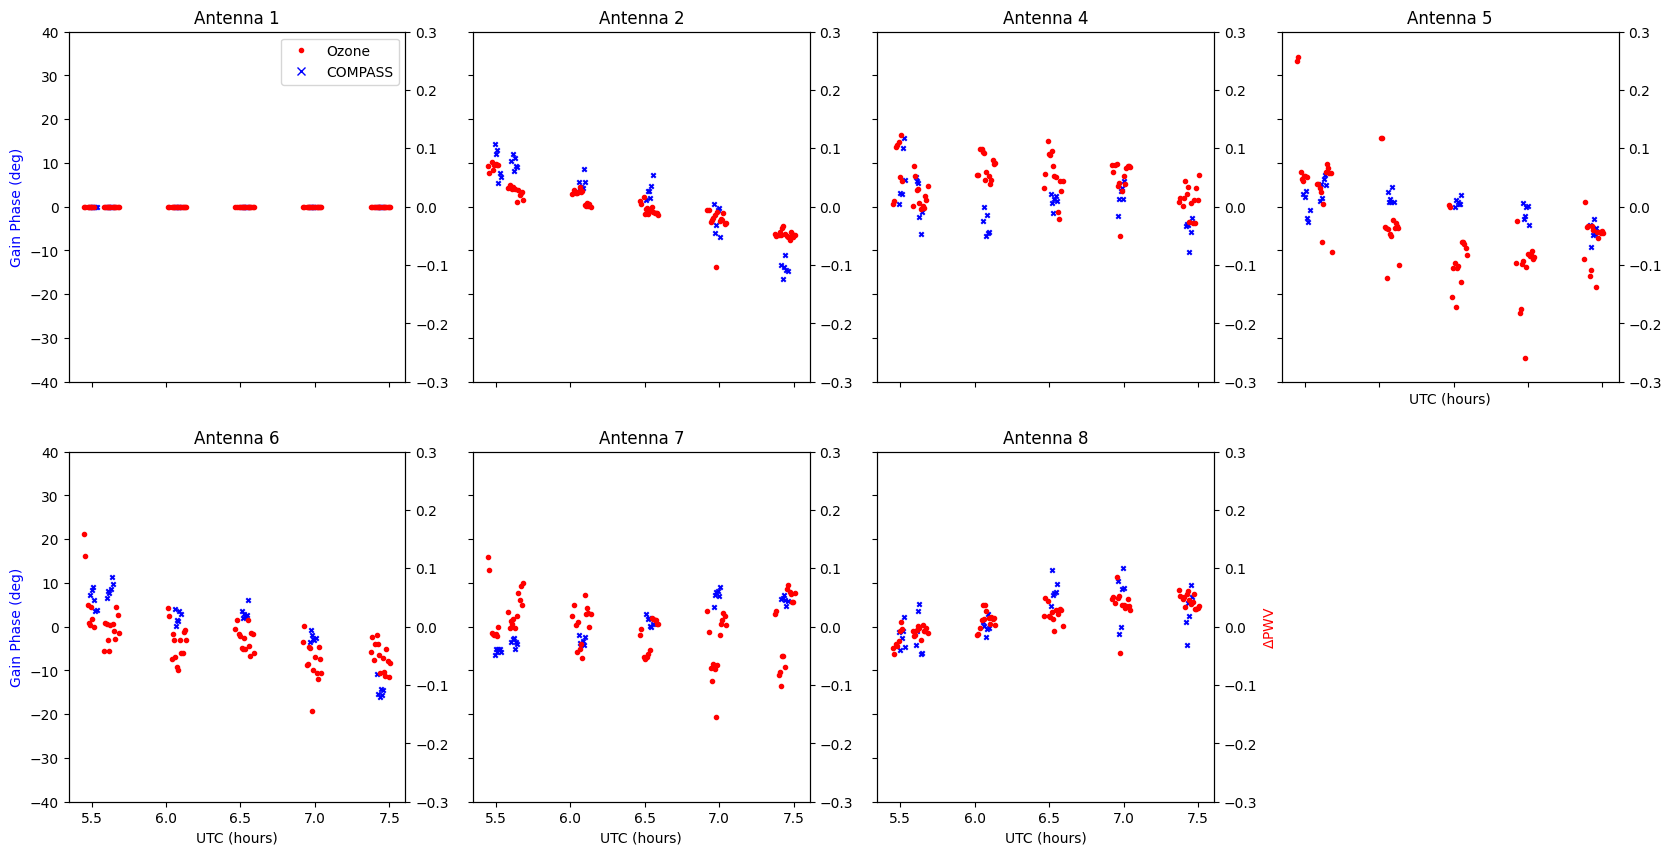

In [60]:
compass_solns = h5py.File('../src/data/10923_specsoln.mat')
ant = [1, 2, 4, 5, 6, 7, 8]
refant = 1
spw = 4
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
_, _, ref_dpwv = np.loadtxt("Antenna_%g_SPW%g_Time_El_dPWV.csv" % (refant, spw), unpack=True)
delta = 0.05
max_ang = 40

for idx, antnum in enumerate(ant):
    utc, el, dpwv = np.loadtxt("Antenna_%g_SPW%g_Time_El_dPWV.csv" % (antnum, spw), unpack=True)

    rereffed_soln = compass_solns['gainWinSolns'][...].view('<c16')[:,antnum-1,0,0] * compass_solns['gainWinSolns'][...].view('<c16')[:,refant-1,0,0].conjugate()
    rereffed_dpwv = dpwv - ref_dpwv


    mask = np.zeros_like(utc, dtype=bool)

    for jdx, t in enumerate((compass_solns['gainWinTimes'][0] % 1)*24):
        if compass_solns['gainWinSouID'][0][jdx] == 2:
            continue
        mask |= (utc >= (t - delta)) & (utc <= (t + delta))
    
    #mask[mask] &= (compass_solns['gainWinSouID'][0] == 1)

    ax.flatten()[idx].scatter((compass_solns['gainWinTimes'][0] % 1)[compass_solns['gainWinSouID'][0]==1]*24,
                              np.degrees(np.angle(rereffed_soln))[compass_solns['gainWinSouID'][0] == 1], 10, marker='x', color='b')
    ax2 = ax.flatten()[idx].twinx()
    ax2.set_title("Antenna %g" % antnum)
    ax2.plot(utc[mask], rereffed_dpwv[mask], 'r.', label = "Ozone")
    ax2.plot(np.nan, np.nan, 'bx', label = "COMPASS")
    if antnum==1:
        ax2.legend()
    #ax2.set_ylim(-1.272018 * np.radians(max_ang) / (2 * np.pi), 1.272018 * np.radians(max_ang) / (2 * np.pi))
    ax2.set_ylim(-0.3, 0.3)

ax[0, 0].set_ylabel("Gain Phase (deg)", color='b')
ax[1, 0].set_ylabel("Gain Phase (deg)", color='b')

ax[0, 0].set_ylim(-max_ang, max_ang)
#ax2[0, 3].set_ylabel("$\\Delta$PWV", color='r')
ax2.set_ylabel("$\\Delta$PWV", color='r')
for i in range(4):
    ax[1, i].set_xlabel("UTC (hours)")

ax[0, 3].set_xlabel("UTC (hours)")
ax[1, 3].axis('off')
#ax2.set_xlabel('UTC (Hours)')
#ax.set_ylabel(')', color='blue')
#ax2.set_ylabel("$\\Delta$PWV", color='r')

In [52]:
 freqs[3, 1][14000]

np.float64(235.6824203364349)

In [21]:
utc

array([4.96533422, 4.97357943, 4.98182464, 4.99006987, 4.99831508,
       5.00656028, 5.07682383, 5.08506906, 5.09331425, 5.10155948,
       5.10980469, 5.11804992, 5.13454033, 5.14278556, 5.15103078,
       5.159276  , 5.16752118, 5.17576641, 5.1840116 , 5.19225683,
       5.20050202, 5.20874724, 5.21699244, 5.22523768, 5.23348287,
       5.24172812, 5.24997333, 5.25821852, 5.26646373, 5.27470895,
       5.28295414, 5.29119935, 5.29944455, 5.30768977, 5.31593499,
       5.32418018, 5.33242539, 5.3406706 , 5.34891583, 5.35716102,
       5.36540624, 5.37365144, 5.38189666, 5.39014186, 5.39838704,
       5.40663227, 5.41487747, 5.4231227 , 5.43136791, 5.4396131 ,
       5.44785832, 5.45610355, 5.47259395, 5.48083919, 5.48908438,
       5.49732961, 5.5055748 , 5.51382002, 5.58408356, 5.59232879,
       5.60057401, 5.60881922, 5.61706444, 5.62530964, 5.64180004,
       5.65004525, 5.65829049, 5.66653569, 5.67478089, 5.68302614,
       5.69951653, 5.70776177, 5.71600698, 5.72425217, 5.73249